# Logistic Regression

## Import Library

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

## Load dataset

In [2]:
df = pd.read_csv("kddcup99_csv.csv", header=0)
print("rows of original dataset:", len(df))
print(df.head())
print("unique protocol_type:", df['protocol_type'].unique())
print("unique service:", df['service'].unique())
print("unique flag:", df['flag'].unique())
print("unique labels:", df['label'].unique())

rows of original dataset: 494020
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0       

## Preprocessing

In [3]:
# Get abnormal df
df_abnormal = df[df.iloc[:, -1] != 'normal']

# One-hot encode categorical features
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df_abnormal[['protocol_type', 'service', 'flag']])

# Convert sparse matrix to a DataFrame and reset the index
df_encoded = pd.DataFrame(df_encoded.toarray(), columns=encoder.get_feature_names_out())
df_encoded.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from df_abnormal
df_abnormal_dropped = df_abnormal.drop(columns=['protocol_type', 'service', 'flag']).reset_index(drop=True)

# Combine df_encoded (one-hot encoded) and df_abnormal_dropped (the rest of the columns)
df_filtered = pd.concat([df_abnormal_dropped, df_encoded], axis=1)

# Classify data into probe attack and not probe classes
PROBE_ATTACK = ['ipsweep', 'nmap', 'portsweep', 'satan']
df_filtered['attack_class'] = df_filtered['label'].apply(
    lambda x: 0 if x in PROBE_ATTACK else 1
)

# Remove column "label"
df_filtered.drop(columns=['label'], inplace=True)



# Count number of probe and non-probe attacks
probe_num = (df_filtered['attack_class'] == 0).sum()
nonprobe_num = (df_filtered['attack_class'] == 1).sum()

# Display the filtered dataframe
print("Rows of filtered data:", len(df_filtered))
print(f"Number of probe attacks: {probe_num}, number of non-probe attacks: {nonprobe_num}")
print(df_filtered.head())

Rows of filtered data: 396743
Number of probe attacks: 4107, number of non-probe attacks: 392636
   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0       184       1511       2957     0               0       0    3   
1       305       1735       2766     0               0       0    3   
2        79        281       1301     0               0       0    2   
3        25        269       2333     0               0       0    0   
4         0          0          0     0               0       0    0   

   num_failed_logins  logged_in  lnum_compromised  ...  flag_RSTO  \
0                  0          1                 2  ...        0.0   
1                  0          1                 2  ...        0.0   
2                  0          1                 1  ...        0.0   
3                  0          1                 0  ...        0.0   
4                  0          0                 0  ...        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  f

## Resample data

In [4]:
# Split the DataFrame into features (X) and target (y)
X = df_filtered.iloc[:, :-1]  # All columns except the last one (features)
y = df_filtered['attack_class']  # The 'attack_class' column (target)

# Balance the dataset using undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Count number of probe and non-probe attacks
probe_num = (y_resampled == 0).sum()
nonprobe_num = (y_resampled == 1).sum()

# Display the resampled dataframe
print("Rows of resampled data:", len(X_resampled))
print(f"Number of probe attacks: {probe_num}, number of non-probe attacks: {nonprobe_num}")

Rows of resampled data: 8214
Number of probe attacks: 4107, number of non-probe attacks: 4107


## Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

## Training the Logistic Regression Model

In [6]:
# Train the model
MAX_ITER = 10000
model = LogisticRegression(max_iter=MAX_ITER)
model.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc}")
print(f"Testing Accuracy: {test_acc}")

Training Accuracy: 0.9998478161619236
Testing Accuracy: 0.9981740718198417


The model doesn't overfit, because it perform well on both train and test data.

In [7]:
print(f"Converged in {model.n_iter_[0]} iterations")

# Feature importance (absolute value of weights)
feature_importances = abs(model.coef_[0])
important_features = sorted(
    zip(X_resampled, feature_importances), key=lambda x: x[1], reverse=True)
print("Top features:", important_features[:10])

Converged in 758 iterations
Top features: [('diff_srv_rate', 4.651930483438253), ('dst_host_diff_srv_rate', 4.053408404832917), ('dst_host_same_src_port_rate', 3.4937000958566258), ('dst_host_serror_rate', 2.8786853754919677), ('dst_host_rerror_rate', 1.7842229530226013), ('service_other', 1.715511327969973), ('same_srv_rate', 1.6215362698994478), ('wrong_fragment', 1.3278535300701426), ('flag_REJ', 1.270756098499238), ('protocol_type_udp', 1.1505623637255467)]


`diff_srv_rate` means percent of connections to different services.  `dst_host_diff_srv_rate` means percent of destination host to different services. `dst_host_same_src_port_rate` means percent of destination host to same source port.The top ten features all looks highly related to attack class.
Probe attacks are typically used to scan systems or networks for information such as open ports, running services, or system configurations. This reconnaissance helps attackers understand the target system's architecture, vulnerabilities, and weaknesses. Many of the features indicate target system's architecture weakness.

## L1 vs L2 Regularization

In [8]:
# L1 Regularization
model_l1 = LogisticRegression(penalty='l1', solver="saga", max_iter=MAX_ITER)
model_l1.fit(X_train, y_train)

# L2 Regularization
model_l2 = LogisticRegression(penalty='l2', max_iter=MAX_ITER)
model_l2.fit(X_train, y_train)

# Calculate and compare accuracies
train_acc_l1 = accuracy_score(y_train, model_l1.predict(X_train))
test_acc_l1 = accuracy_score(y_test, model_l1.predict(X_test))

In [9]:
train_acc_l2 = accuracy_score(y_train, model_l2.predict(X_train))
test_acc_l2 = accuracy_score(y_test, model_l2.predict(X_test))

print(f"L1 - Converged in {model_l1.n_iter_[0]} iterations")
print(f"L2 - Converged in {model_l2.n_iter_[0]} iterations")

print(f"L1 - Training Accuracy: {train_acc_l1}, Testing Accuracy: {test_acc_l1}")
print(f"L2 - Training Accuracy: {train_acc_l2}, Testing Accuracy: {test_acc_l2}")

L1 - Converged in 7770 iterations
L2 - Converged in 758 iterations
L1 - Training Accuracy: 0.5119464312889971, Testing Accuracy: 0.5045648204503956
L2 - Training Accuracy: 0.9998478161619236, Testing Accuracy: 0.9981740718198417


The L2 model converge more quickly and L2 have a better accuracy. L1 performs bad on this dataset

## Varying Regularization Strength

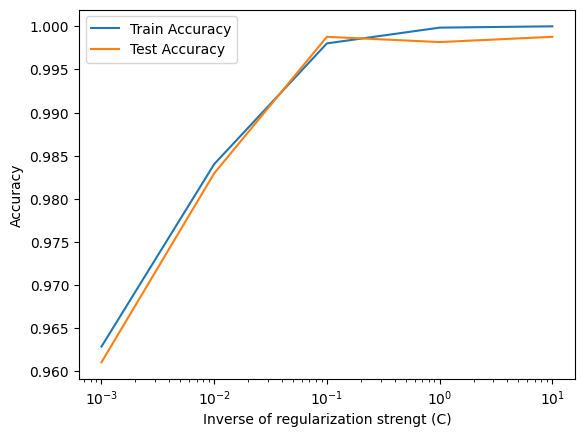

In [10]:
inverse_regularization_strengths = [0.001, 0.01, 0.1, 1, 10]
train_accuracies = []
test_accuracies = []

for c in inverse_regularization_strengths:
    model_l2 = LogisticRegression(penalty='l2', C=c, max_iter=MAX_ITER)
    model_l2.fit(X_train, y_train)

    train_accuracies.append(accuracy_score(y_train, model_l2.predict(X_train)))
    test_accuracies.append(accuracy_score(y_test, model_l2.predict(X_test)))

plt.plot(inverse_regularization_strengths, train_accuracies, label='Train Accuracy')
plt.plot(inverse_regularization_strengths, test_accuracies, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('Inverse of regularization strengt (C)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Different regualrization have different accuracy. In this dataset, higher inverse regularization strength have a higher accuracy. In other word, smaller regularization strength have a higher accuracy